In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

1) Log file is loaded

In [2]:
file = open("log.txt", "r") 
lines = file.readlines()
for l in range(3): print(lines[l][:-1])

156.15.13.173 [01/Jan/2018:11:13:49 +0100] "GET AddProduct.html HTTP/1.0" 200 2356
176.247.135.49 [01/Jan/2018:11:18:07 +0100] "GET Shop.html HTTP/1.0" 200 7466
176.247.135.49 [01/Jan/2018:11:19:05 +0100] "GET AddProduct.html HTTP/1.0" 200 2356


2) Cass "Request" parses and keeps data of a single requests. Complete the TODO, where a given "line" (string) should be parsed in order to dervie the ip of the host making the request, time of the request (in seconds), and target page (name).

In [3]:
import re
class Request:
    def __init__(self, line):
        # IP address
        ip = re.search('[0-9]{1,3}[.][0-9]{1,3}[.][0-9]{1,3}[.][0-9]{1,3}', line)
        self.ip = ip.group(0)
        
        # Convert hours + minutes + seconds and generate total number of seconds
        time = re.search('[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2}', line)
        splited = time.group(0).split(':') # 0 - year, 1 - hour, 2 - minutes, 3 - seconds
        self.time = (int(splited[1]) * 3_600) + ((int(splited[2]) - 1) * 60) + int(splited[3]) - 1
        
        # Page
        page = re.search('[0-9A-z]+[.]html', line)
        self.page = page.group(0)
        
    def __repr__(self):
        return self.ip + "     " +  str(datetime.timedelta(seconds=self.time)) + " -> " + self.page

3) Each line of log.txt is parsed and the Request objects are added to the list

In [4]:
reqs = [Request(line) for line in lines]
for l in range(10): print(reqs[l]) 

156.15.13.173     11:12:48 -> AddProduct.html
176.247.135.49     11:17:06 -> Shop.html
176.247.135.49     11:18:04 -> AddProduct.html
176.247.135.49     11:28:04 -> Summary.html
69.84.30.199     11:42:58 -> Shop.html
69.84.30.199     11:44:15 -> AddProduct.html
57.116.45.120     11:45:44 -> AddProduct.html
69.84.30.199     11:49:35 -> Summary.html
69.84.30.199     11:51:37 -> Payment.html
26.19.183.202     11:52:10 -> AddProduct.html


# Exercise

Your task is to analyze the log file. You should indentify the users and sessions. Then, compute the following: <br>
[DONE] 3.1) the number of sessions (should be 1000 :) ), <br>
[DONE] 3.2) the number of users (391), <br>
[DONE] 3.3) the average number of sessions per one user <br>
[DONE] 3.4) use the distribution plot to visualize the sessions' lengths (minutes);  <br>
[DONE] 3.5) use the distribution plot to visualize the sessions' lengths (the number of requests) <br>
[DONE] 3.6) use the distribution plot to visualize sessions' starting times (hours). <br>
3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page,  <br>
3.8) which web page is the most common departure point?; for each page plot the number of times the user stopped a session while being on this page, <br>
3.9) for each page plot the average time the user stayed on this page <br>
3.10) print the first 10 sessions (paths). <br>

You may find the following classes helpful and data.

In [44]:
class Session:
    def __init__(self, start, stop, requests):
        self.startTime = start
        self.stopTime = stop
        self.requests = requests
        
    def __repr__(self):
        print("SESSION")
        print(self.startTime)
        print(self.stopTime)
        STR = ""
        for r in self.requests:
            print(r)
            STR += ("  " + r.page + "    " + str(datetime.timedelta(seconds=r.time)) + "\n")
        return STR

class Computer:
    def __init__(self, ip, sessions):
        self.ip = ip
        self.sessions = sessions
    def __repr__(self):
        return self.ip

PAGES = ["Shop.html", "AddProduct.html", "Summary.html", "Payment.html","About.html", "Contact.html"]

LINKS = [
         [1, 4],
         [2, 4],
         [3],
         [],
         [1, 5],
         []
        ]

#plot distribution
#count, bins, ignored = plt.hist(data, 50, alpha=0.5, normed=True)
#plt.plot()

#x_axis = np.arange(len(pages))
#plt.bar(x_axis, data, align='center', alpha=0.5)
#plt.xticks(y_pos, pages, rotation=90)

In [27]:
# Task 1 - Sessions
MAX_SESSION_TIME = 15 * 60 # 15 minutes
ip_addresses_with_requests = {}
SESSIONS = []

# Group requests by user's IP
for r in reqs:
    record = ip_addresses_with_requests.get(r.ip, [])
    record.append(r)
    ip_addresses_with_requests.update({r.ip: record})

# Check requests and generate Sessions structures
for key, val in ip_addresses_with_requests.items():
    # Local variables with UNIX start & end session time, requests inside session
    startTime = 0
    stopTime = 0
    requests = []
    lastPageID = 0
        
    for visit in val:
        # Request inside session
        if (stopTime + MAX_SESSION_TIME) > visit.time:
            currentPageID = PAGES.index(visit.page)
            
            # Last page and current with link
            if (currentPageID in LINKS[lastPageID]):
                stopTime = visit.time
                requests.append(visit)
                lastPageID = currentPageID
            else:
                # Store session and start new
                SESSIONS.append(Session(startTime, stopTime, requests))
                startTime = visit.time
                stopTime = visit.time
                requests = [visit]
                lastPageID = currentPageID
        else:
            # Append already prepared Session record
            if startTime != 0:
                new_session = Session(startTime, stopTime, requests)
                SESSIONS.append(new_session)
                requests = []
            
            # Start new session
            startTime = visit.time
            stopTime = visit.time
            requests.append(visit)
            lastPageID = PAGES.index(visit.page)
    
    # Append last record - exit page
    SESSIONS.append(Session(startTime, stopTime, requests))
    
# Calculate total sessions and show message
TOTAL_SESSIONS = len(SESSIONS)
print('Total sessions:', TOTAL_SESSIONS)

Total sessions: 1000


In [28]:
# Task 2 - Unique IP addresses
USERS = ip_addresses_with_requests
USERS_COUNT = len(USERS.keys())

print('Unique IP addresses count:', USERS_COUNT)

Unique IP addresses count: 391


In [43]:
# Task 3 - The average number of sessions per one user
print('Average number of sessions per user:', TOTAL_SESSIONS/USERS_COUNT)

Average number of sessions per user: 2.557544757033248


Sessions' length in minutes


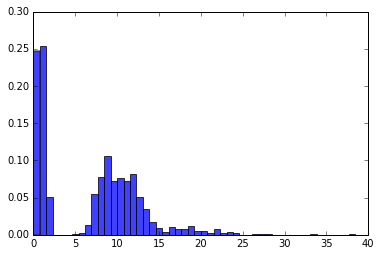

In [72]:
# Task 4 - The distribution plot - the sessions' lengths (minutes)
sessions_length_minutes = list()
for session in SESSIONS:
    sessions_length_minutes.append((session.stopTime - session.startTime) / 60)

plt.hist(sessions_length_minutes, 50, alpha=0.75, normed=True)
plt.plot()
print('Sessions\' length in minutes')

Sessions' length in requests


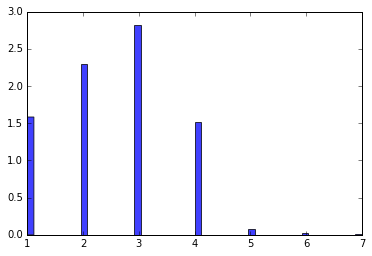

In [73]:
# Task 5 - The distribution plot - the sessions' lengths (number of requests)
sessions_length_requests = list()
for session in SESSIONS:
    sessions_length_requests.append(len(session.requests))

plt.hist(sessions_length_requests, 50, alpha=0.75, normed=True)
plt.plot()
print('Sessions\' length in requests')

Sessions' times (hours)


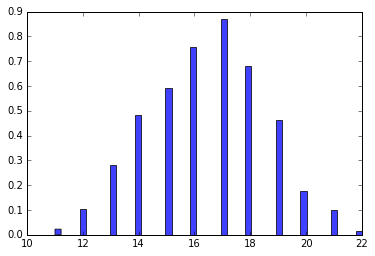

In [81]:
# Task 6 - The distribution plot - the sessions' starting times (hours)
import time
sessions_length_requests = list()
for session in SESSIONS:
    startHour = time.gmtime(session.startTime).tm_hour
    sessions_length_requests.append(startHour)

plt.hist(sessions_length_requests, 50, alpha=0.75, normed=True)
plt.plot()
print('Sessions\' times (hours)')

Sessions' entry points


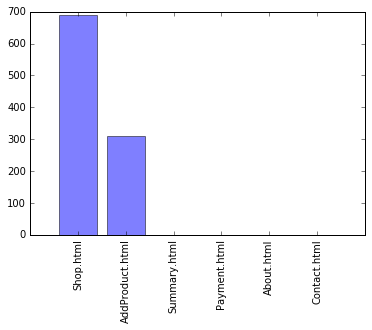

In [103]:
# Task 7 - which web page is the most common entry point?
#          for each page plot the number of times it has been an entry page
sessions_entry_points = np.zeros(len(PAGES))
for session in SESSIONS:
    pageID = PAGES.index(session.requests[0].page)
    sessions_entry_points[pageID] += 1

x_axis = np.arange(len(PAGES))
plt.bar(x_axis, sessions_entry_points, align='center', alpha=0.5)
plt.xticks(x_axis, PAGES, rotation=60)
print('Sessions\' entry points')